In [1]:
import sys
print(sys.executable)

/Users/login/miniconda3/envs/skbio2/bin/python


The purpose of this file is to load the ASV table, load and compare clustered sequences, check each for structural artifacts with a PCA paired with a Chi-Squared test, make some diagnostic figures, remove low frequency features, compare UNIFRAC-type and conventional distances between samples, and then make a hierarchy visualize the similarities between samples, and save the final output matrix.

#### Step 1: Load packages and OTU abundance table

In [2]:
import os
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import yaml

# load raw abundance data
abund_feather = '../otu_data/tree_data/hq_asv_table.feather'
abund_tsv = "../otu_data/tree_data/hq_asv_table.tsv"
if not os.path.exists(abund_feather):
    abund_df = pd.read_csv(abund_tsv, sep="\t")
    abund_df.to_feather(abund_feather)
else:
    abund_df = pd.read_feather(abund_feather, use_threads=True).set_index('Samples')
    
print("Read in abundance table with {} rows and {} columns".format(abund_df.shape[0], abund_df.shape[1]))
# load full sample sheet
config_file = "config.yml"
with open(config_file, 'r') as stream:
    cfg_dict = yaml.safe_load(stream)

data_dir = cfg_dict['data_directory']
sample_sheet_fn = cfg_dict['sample_sheet']
sample_sheet = pd.read_csv(sample_sheet_fn, sep="\t")
print("Read in metadata table with {} rows and {} columns".format(sample_sheet.shape[0], sample_sheet.shape[1]))

# Fix weird date
sample_sheet.loc[sample_sheet['DateMMDDYY'] == 'Mix9', 'DateMMDDYY'] = '100516'

# make weird samples (not mine or controls, some not in sample sheet) their own group 
weird_samples = set(abund_df.index) - set(sample_sheet.SampleID.unique())
abund_df_jm = abund_df.drop(weird_samples, axis=0)
print("After removing others' samples abundance table size is {}".format(abund_df_jm.shape))

Read in abundance table with 441 rows and 54467 columns
Read in metadata table with 413 rows and 77 columns
After removing others' samples abundance table size is (407, 54467)


#### Prep the sample sheet 

In [3]:
sample_sheet2 = sample_sheet.set_index('SampleID')
sub_sample_sheet = sample_sheet2.loc[abund_df_jm.index, :]
sub_sample_sheet.loc[sub_sample_sheet.DepthName.isnull(), 'DepthName'] = 'LAB'
sub_sample_sheet.loc[sub_sample_sheet.DepthName == 'Surface', 'DepthName'] = '1'
sub_sample_sheet.loc[sub_sample_sheet.DepthName == '0', 'DepthName'] = '1'
select_metadata = ['DateMMDDYY', 'StationName', 'DepthName', 'sequencing ID']

lat_lon_fn = "../otu_data/CB_Locations.tsv"
lat_lon = pd.read_csv(lat_lon_fn, sep="\t", index_col=0)
cb2lat, cb2lon = {'LAB': 00.0}, {'LAB': 00.0}

for stat_ in lat_lon.index:
    if stat_.replace(".", "") in sub_sample_sheet.StationName.unique():
        cb2lat[stat_.replace(".", "")] = round(lat_lon.loc[stat_, 'Latitude'], 3) 
        cb2lon[stat_.replace(".", "")] = round(lat_lon.loc[stat_, 'Longitude'], 3) 


sub_sample_sheet['Latitude'] = sub_sample_sheet.StationName.map(cb2lat)
sub_sample_sheet['Longitude'] = sub_sample_sheet.StationName.map(cb2lon)

read_counts = pd.read_csv("../otu_data/trim_stats/read_counts.tsv", sep="\t", header=None, index_col=0)
sub_reads = read_counts.loc[sub_sample_sheet.index, :]
sub_reads.columns = ['RawCount', 'TrimCount']

read_bins = [5e3, 1e4, 2.5e4, 5e4, 1e5, 2.5e5, 5e5, 1e6, 2.5e6]
read_discrete = pd.DataFrame(index=sub_reads.index, columns=['RawCount_b', 'TrimCount_b'],
                            data=np.zeros(sub_reads.shape))
for rb in read_bins:
    r_bool = sub_reads['RawCount'] >= rb
    read_discrete.loc[r_bool, 'RawCount_b'] += 1
    t_bool = sub_reads['TrimCount'] >= rb
    read_discrete.loc[t_bool, 'TrimCount_b'] += 1
    print("{} and {} libraries incremented".format(r_bool.sum(), t_bool.sum()))

meta_data_df = sub_sample_sheet.join(sub_reads).join(read_discrete)

394 and 387 libraries incremented
390 and 375 libraries incremented
375 and 341 libraries incremented
353 and 297 libraries incremented
310 and 185 libraries incremented
154 and 31 libraries incremented
43 and 6 libraries incremented
2 and 0 libraries incremented
0 and 0 libraries incremented


#### Here we will define a function that drops features present mostly in controls and samples with low yields

In [4]:
control_libs = (['178A_WaterBathControlA', '178B_WaterBathControlB'])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("Blank")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("Mix9")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("CDSBBR")])
control_libs += list(abund_df_jm.index[abund_df_jm.index.str.contains("EMPTY")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("_Neg")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("ML0")])
control_libs += list(abund_df_jm.index[meta_data_df['Short sample name'].str.contains("_Pos")])
control_libs = list(set(control_libs))

def decrease_sparsity(abund_table, ctrls, abund_thresh=5, rare_thresh=3000, addl_keys=[]):
    """Takes an abundance table and a list of control indexes
       Removes OTUs with 50% or more of their abundances in controls.
       Removes OTUS below user set abundances threshold.
       Removes features below rarefaction threshold.
       Removes additional features according to string matched key"""
    otus_to_strip = set()
    control_otus = abund_table.columns[abund_table.loc[ctrls, :].sum() > 0]
    total_in_controls = abund_table.loc[ctrls, control_otus].sum()
    total_in_non_controls = abund_table.loc[:, control_otus].sum()
    mostly_in_controls = control_otus[(total_in_controls / total_in_non_controls) > 0.5]
    otus_to_strip.update(mostly_in_controls)
    print("{} are to be removed as contaminants".format(len(otus_to_strip)))
    otus_to_strip.update(abund_table.columns[abund_table.sum() < abund_thresh])
    print("{} are to be removed after adding low abundance OTUs".format(len(otus_to_strip)))
    presence_absence = ((abund_table > 0))
    infrequent_appearances = abund_table.columns[presence_absence.sum() < 2]
    otus_to_strip.update(infrequent_appearances)
    print("{} are to be removed after adding low freq OTUs".format(len(otus_to_strip)))
    div_samples = presence_absence.sum(1)
    div_thresh = div_samples["96_ZymoControl_R1"]
    print("Removing samples with fewer features than Zymo ({})".format(div_thresh))
    abund_to_return = abund_table.copy()
    for ak in addl_keys: 
        ctrls += list(abund_table.index[abund_table.index.str.contains(ak)])
    
    ctrls += list(abund_table.index[div_samples < div_thresh])
    fmt_libs = "".join(["\t"+cl+"\n" for cl in ctrls])
    print("Removed libraries are:\n{}".format(fmt_libs))
        
    abund_to_return = abund_to_return.loc[~(abund_table.index.isin(ctrls)), 
                                          ~abund_table.columns.isin(otus_to_strip)]
    
    abund_to_return2 = abund_to_return[(abund_to_return.sum(1) >= rare_thresh)]
    
    print("{}, {}, {} are shapes after removing low yield, nonsample otus".format(abund_table.shape, 
                                                                                  abund_to_return.shape, 
                                                                                  abund_to_return2.shape))
    return abund_to_return2

print("Decreasing sparsity of full table:")
abund_df_og = decrease_sparsity(abund_df_jm, control_libs, addl_keys=['Zymo'])

Decreasing sparsity of full table:
1894 are to be removed as contaminants
22499 are to be removed after adding low abundance OTUs
34897 are to be removed after adding low freq OTUs
Removing samples with fewer features than Zymo (12)
Removed libraries are:
	SB062917TAWCSLABDPCBR1TR1I607
	SB062917TAWCSLABDPCBR1TR2I606
	SB082015TAWCSCB33CDSBBR1TR1I50
	SB062917TAWCSLABDPCBR1TR3I608
	93_PBS_Blank_Control
	178B_WaterBathControlB
	SB062917TAWCSLABDPCBR1TR4I609
	SB062716TAWCSLABDPCBR1TR1I602
	SB072215TAWCSCB33CDSBBR1TR1I26
	178A_WaterBathControlA
	SB072516TAWCSCB33CDSBBR1TR1I125
	SB092116TAWCSLABDNCBR1TR1I247
	SB092616TAWCSLABDNABR1TR1I268
	SB061815TAWCSCB33CDSBBR1TR1I2
	92_Mix93_Control_R2
	SB062716TAWCSLABDNCBR1TR1I601
	92_Mix93_Control_R1
	SB062716TAWCSCB33CDSBBR1TR1I93
	SBMix9TAWCSLABDPCBR1TR2I270
	96_ZymoControl_R1
	SB071017TAWCSCB62D9BR1TR1I414
	SB061815TAWCSCB33CD10BR2TR1I14
	SB061815TAWCSCB33CD12BR1TR1I16
	SB061815TAWCSCB33CD16BR1TR1I20
	SB061815TAWCSCB33CD5BR1TR1I8
	SB072215TAWCSCB33C

In [30]:
taxa_file = "taxa_table.tsv"
data_path = "../otu_data/dada2_outputs"
tax_f = os.path.join(data_path, taxa_file)
taxa_df = pd.read_csv(tax_f, sep="\t")
OTU_Seqs = {taxa_df.loc[idx, taxa_df.columns[0]]:idx for idx in taxa_df.index}
OTU_Names = {idx:"OTU{}".format(idx+1) for idx in taxa_df.index }
OTU_name2seq = {OTU_Names[num]:seq for seq, num in OTU_Seqs.items()}
taxa_df.loc[:, taxa_df.columns[0]] = taxa_df.loc[:, taxa_df.columns[0]].apply(lambda x: OTU_Names[OTU_Seqs[x]])
taxa_df = taxa_df.set_index(taxa_df.columns[0])
#taxa_df.loc[['OTU15257', 'OTU30263', 'OTU2'], :]
taxa_df.loc[['OTU2880', 'OTU14561', 'OTU38271', "OTU54666"], :]

#OTU13729

,Kingdom,Phylum,Class,Order,Family,Genus,Species
Unnamed: 0,,,,,,,
OTU2880,Archaea,NaN,NaN,NaN,NaN,NaN,NaN
OTU14561,Archaea,NaN,NaN,NaN,NaN,NaN,NaN
OTU38271,Archaea,NaN,NaN,NaN,NaN,NaN,NaN
OTU54666,Archaea,Nanoarchaeaeota,Woesearchaeia,NaN,NaN,NaN,NaN


#### This modifies the format of the tree produced by the [MAFFT webserver](https://mafft.cbrc.jp/alignment/server/large.html) and writes the new tree file with the paired abundance table 

In [92]:
dist_file = "../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.dist.tab"
dist_out = "../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.dist.mod.tab"

triang_arr = [[0]]
rec_n = 1
with open(dist_file, "r") as dih:
    for ix, l in enumerate(dih):
        rec_n += 1
        triang_arr.append(l.replace("S", "").replace("P", "").split()+[0.])
        

full_arr = np.array([x+[0.0]*(rec_n-len(x)) for x in triang_arr], dtype=float)
dist_df = pd.DataFrame(full_arr + full_arr.T)


### Here we will read in pplacer file and collapse the abundance table according to edge placements

In [77]:
import matplotlib.pyplot as plt
# read in the usearch data
pp_file = "../otu_data/clustered_sequences/abundances.pp.tsv"
if not os.path.exists(pp_file):
    pplacements = '../otu_data/tree_data/full_tree/query_cmsearched.hug_tol.clean.align.csv'
    pp_df = pd.read_csv(pplacements, index_col=1)
    binned_lwr = pp_df.loc[:, ['edge_num', 'like_weight_ratio']].groupby('edge_num').agg(['mean', 'std'])
    rough_edges.update(binned_lwr[binned_lwr.loc[:, binned_lwr.columns[1]] > 0.3].index)
    rough_edges.update(binned_lwr[binned_lwr.loc[:, binned_lwr.columns[0]] < 0.3].index)
    idx_bools = {idx:pp_df[pp_df.edge_num.isin([idx])].index for idx in sorted(pp_df.edge_num.unique())}
    pooled_pp_df = pd.DataFrame(index=abund_df_jm.index, columns=sorted(pp_df.edge_num.unique()))
    for idx_, otus_ in idx_bools.items():
        pooled_pp_df.loc[:, idx_] = abund_df_jm.loc[:, otus_].sum(1)

    print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], pooled_pp_df.shape[1]))
    assert pooled_pp_df.sum().sum() - abund_df_jm.sum().sum() == 0
    pooled_pp_df.to_csv(pp_file, sep="\t")
else:
    print("Reading stored Pplacer abundances")
    pooled_pp_df = pd.read_csv(pp_file, sep="\t", index_col=0)
    print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], pooled_pp_df.shape[1]))
    
pooled_pp_ns = decrease_sparsity(pooled_pp_df.copy(), control_libs, addl_keys=['Zymo'])

After clustering 54467 features reduced to 2191
111 are to be removed as contaminants
398 are to be removed after adding low abundance OTUs
499 are to be removed after adding low freq OTUs
Removing samples with fewer features than Zymo (11)
Removed libraries are:
	SB062917TAWCSLABDPCBR1TR1I607
	SB062917TAWCSLABDPCBR1TR2I606
	SB082015TAWCSCB33CDSBBR1TR1I50
	SB062917TAWCSLABDPCBR1TR3I608
	93_PBS_Blank_Control
	178B_WaterBathControlB
	SB062917TAWCSLABDPCBR1TR4I609
	SB062716TAWCSLABDPCBR1TR1I602
	SB072215TAWCSCB33CDSBBR1TR1I26
	178A_WaterBathControlA
	SB072516TAWCSCB33CDSBBR1TR1I125
	SB092116TAWCSLABDNCBR1TR1I247
	SB092616TAWCSLABDNABR1TR1I268
	SB061815TAWCSCB33CDSBBR1TR1I2
	92_Mix93_Control_R2
	SB062716TAWCSLABDNCBR1TR1I601
	92_Mix93_Control_R1
	SB062716TAWCSCB33CDSBBR1TR1I93
	SBMix9TAWCSLABDPCBR1TR2I270
	96_ZymoControl_R1
	SB071017TAWCSCB62D9BR1TR1I414
	SB061815TAWCSCB33CD10BR2TR1I14
	SB061815TAWCSCB33CD12BR1TR1I16
	SB061815TAWCSCB33CD16BR1TR1I20
	SB061815TAWCSCB33CD5BR1TR1I8
	SB072215TA

check how tight our pools are 

In [118]:

def most_frequent(List): 
    return max(set(List), key = List.count)

good_edges = {}
for edge, members in idx_bools.items():
    taxa_rows = taxa_df.loc[members, :]
    if taxa_rows.shape[0] > 2:
        classified_ = taxa_rows.isnull().sum() / taxa_rows.shape[0] < 0.5
        if classified_[classified_].shape[0] > 0:
            lowest_level = classified_[classified_].index[-1]
            if not lowest_level in ['Kingdom', 'Phylum',]:
                good_edges[edge] = [most_frequent(taxa_rows.loc[:, i].tolist()) for i in taxa_df.columns]
    else:
        good_edges[edge] = [most_frequent(taxa_rows.loc[:, i].tolist()) for i in taxa_df.columns]

edge_taxa = pd.DataFrame(good_edges, index=taxa_df.columns).T
edges_c1 = edge_taxa[edge_taxa.Class == 'Alphaproteobacteria']
edges_c2 = edge_taxa[edge_taxa.Class == 'Deltaproteobacteria']

edge_nums1 = np.random.choice(edges_c1.index, size=(5,), replace=False)
edge_nums2 = np.random.choice(edges_c2.index, size=(5,), replace=False)

print("cross", dist_df.loc[edge_nums1, edge_nums2].mean().mean())
print("within 1", dist_df.loc[edge_nums1, edge_nums1].mean().mean())
print("within 2", dist_df.loc[edge_nums2, edge_nums2].mean().mean())



cross 1.1231870000000002
within 1 0.43861688
within 2 0.59106312


#### Lets make PCA plots colored by metadata columns

In [115]:
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr

rename_cols = {i - 1: 'PC' + str(i) for i in range(1, 3)}

#abundance_tables = {'Original':abund_df_og.copy(),
#                   'PPlacer Clustered': pooled_pp_ns.copy(),
#                   'UCLUSTered': clust_90_ns.copy()}

abundance_tables = {'Original':abund_df_og.copy()}

sample_loadings = {}
for title_i, abund_i in abundance_tables.items():
    print("Transforming {} abundance table".format(title_i))
    rclr_i = rclr().fit_transform(abund_i.values)
    print("Decomposing {} abundance table".format(title_i))
    opt_i = OptSpace(rank=2).fit(rclr_i)
    sl_i = pd.DataFrame(opt_i.sample_weights, index=abund_i.index)
    sl_i = sl_i.rename(columns=rename_cols)
    sample_loadings[title_i] = sl_i


Transforming Original abundance table
Decomposing Original abundance table


In [54]:
sid_map = {'esakows1_132789': 'e_13',
           'controls': 'controls',
           'esakows1_152133_plate_1': 'e_15_1',
           'esakows1_152133_plate_2': 'e_15_2',
           'Keith_Maeve1_138650': 'KM',
           'Miseq_data_SarahPreheim_Sept2016': 'Miseq_sp',
           'sprehei1_123382': 'spr12',
           'sprehei1_149186': 'spr14'}

print(meta_data_df.loc[abund_df_og.index, "sequencing ID"].unique())
meta_data_df.loc[:, 'sequencing_ID'] = meta_data_df.loc[:, 'sequencing ID'].map(sid_map)
meta_data_df.loc[control_libs, "sequencing_ID"] = 'controls'
select_metadata.remove("sequencing ID"); select_metadata.append("sequencing_ID");
print(meta_data_df.loc[:, "sequencing_ID"].unique(), "\n", select_metadata)

['esakows1_132789' 'esakows1_152133_plate_1' 'esakows1_152133_plate_2'
 'Keith_Maeve1_138650' 'Miseq_data_SarahPreheim_Sept2016'
 'sprehei1_123382' 'sprehei1_149186']
['e_13' 'controls' 'e_15_1' 'e_15_2' 'KM' 'Miseq_sp' 'spr12' 'spr14'] 
 ['DateMMDDYY', 'StationName', 'DepthName', 'sequencing_ID']


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
plt.style.use('seaborn-talk')

meta_data_df2 = meta_data_df.loc[abund_df_og.index, :]
select_mdata = select_metadata + ['Latitude', 'Longitude', 'RawCount_b', 'TrimCount_b']

metas_ls = {'encoded':{}, 'raw':{}, 'encoding':{}, 'rev_coding':{}}
for sm in select_mdata:
    nct = meta_data_df2[sm].isnull().sum()
    metas_ls['raw'][sm] = meta_data_df2[sm].tolist()
    metas_ls['encoding'][sm] = {raw:code for code, raw in enumerate(sorted(set(metas_ls['raw'][sm])))}
    metas_ls['encoded'][sm] = [metas_ls['encoding'][sm][r] for r in metas_ls['raw'][sm]]
    metas_ls['rev_coding'][sm] = {code:raw for raw, code in metas_ls['encoding'][sm].items()}
    uct = len(metas_ls['encoding'][sm])

for title_i in sample_loadings.keys():
    plt.clf()
    fig, ax_i = plt.subplots(nrows=1, ncols=1, figsize=(12,12), dpi=250)
    ax_i.set_title("{}, colored by sequencing run".format(title_i))
    ticks_, labels_ = zip(*metas_ls['rev_coding']['sequencing_ID'].items())
    cmap_i = plt.cm.get_cmap('Spectral', len(labels_))
    im = ax_i.scatter(sample_loadings[title_i].iloc[:, 0], 
                      sample_loadings[title_i].iloc[:, 1], 
                      c=metas_ls['encoded']['sequencing_ID'], 
                      edgecolor='k', alpha=0.8, cmap=cmap_i)
    cbar = fig.colorbar(im, ticks=ticks_)
    cbar.ax.set_yticklabels(labels_)     
    ax_i.set_xlabel(sample_loadings[title_i].columns[0])
    ax_i.set_ylabel(sample_loadings[title_i].columns[1])
    ax_i.set_facecolor('0.6')
    ax_i.set_axisbelow(True)
    ax_i.minorticks_on()
    ax_i.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax_i.grid(which='minor', linestyle='-', linewidth='0.25', color='black')
#    texts = []
#    from adjustText import adjust_text
#    for ctrl_ in control_libs:
#        x = sample_loadings[title_i].loc[ctrl_, 'PC1']
#        y = sample_loadings[title_i].loc[ctrl_, 'PC2']
#        s = meta_data_df2.loc[ctrl_, 'Short sample name'] + "_" + sid_map[meta_data_df2.loc[ctrl_, 'sequencing ID']]
#        texts.append(plt.text(x, y, s))       
#    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    fig.subplots_adjust(right=0.8)
    figname = "PCA_{}_seq_run_colors.png".format(title_i)
    figpath = os.path.join("../otu_data/pca_plots", figname)
    print("Saving {}".format(figname))
    plt.savefig(figpath)
    plt.clf()
    plt.close()

Saving PCA_Original_seq_run_colors.png


<Figure size 748.8x514.8 with 0 Axes>

#### This calculates the inter-run distances, plots their pdfs, and performs Mann-Whitney U test on each pairing 

In [59]:
import seaborn as sns
from skbio.diversity import beta_diversity
groups = meta_data_df2['sequencing_ID'].unique()

def calculate_group_distance(a_label, a_table):
    # subset according to "in" label 
    in_indexes = meta_data_df2[meta_data_df2['sequencing_ID'] == a_label].index
    
    # subset according to "out" label
    out_group = set(groups) - set([a_label]) 
    out_indexes = meta_data_df2[meta_data_df2['sequencing_ID'].isin(out_group)].index
    assert len(out_indexes) + len(in_indexes) == len(a_table.index)
    
    # calculate bray-curtis for all groups
    bc_dists = beta_diversity("braycurtis", a_table.values, a_table.index)
    bc_df = pd.DataFrame(bc_dists._data, index=a_table.index, columns=a_table.index)
    
    # subset rows by "in" and columns by "out" 
    sub_bcdf = bc_df.loc[in_indexes, out_indexes]
    flat_df = pd.DataFrame(sub_bcdf.values.flatten(), columns=[a_label])
    print(a_label, flat_df.shape)
    return (flat_df, flat_df[a_label].mean())

out_data = []
for a_label in groups:
    out_data.append((a_label, calculate_group_distance(a_label, abund_df_og.copy())))
    

flat_dfs = pd.DataFrame({l:fdf[l].sample(4000).values for l, (fdf, m) in out_data})

# calculate average distance 

color_choices = ["sky blue", "olive", "gold", "teal", "rich blue", "wisteria", "lipstick red"]

plt.clf()
f, _axes_ = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=150)
f.suptitle("Samples of all dist hists")
for a_label, cc in zip(groups, color_choices):
    sns.distplot(flat_dfs[a_label], hist=False, axlabel='bray-curtis distance',
                 kde_kws={"label":a_label, 
                          "lw": 3, 
                          "color": sns.xkcd_rgb[cc]}, 
                 ax=_axes_)

plt.legend()
plt.savefig("../otu_data/pca_plots/cross_dists.png", bbox_inches='tight')
plt.show()
plt.clf()
plt.close()

from scipy.stats import mannwhitneyu

pair_tests = pd.DataFrame(index=groups, columns=groups)
for ix in pair_tests.index:
    for cx in pair_tests.columns:
        result = mannwhitneyu(flat_dfs.loc[:, cx].values, flat_dfs.loc[:, ix].values)
        pair_tests.loc[ix, cx] = result[1]*2

sig_level = 0.05/(7*6)
print("Significance level is {}".format(sig_level))
pair_tests < sig_level


e_13 (8944, 1)
e_15_1 (24816, 1)
e_15_2 (19096, 1)
KM (25009, 1)
Miseq_sp (4984, 1)
spr12 (16801, 1)
spr14 (12616, 1)
Significance level is 0.0011904761904761906


,e_13,e_15_1,e_15_2,KM,Miseq_sp,spr12,spr14
e_13,False,True,True,True,True,True,True
e_15_1,True,False,True,False,True,True,True
e_15_2,True,True,False,True,False,True,False
KM,True,False,True,False,True,True,True
Miseq_sp,True,True,False,True,False,True,False
spr12,True,True,True,True,True,False,True
spr14,True,True,False,True,False,True,False


<Figure size 748.8x514.8 with 0 Axes>

#### This creates a plot to show how many OTUs are shared across sequencing runs from the main station (CB33C)

e_13 has 13 libraries
e_15_1 has 9 libraries
e_15_2 has 12 libraries
KM has 38 libraries
Miseq_sp has 14 libraries
spr12 has 53 libraries
spr14 has 12 libraries
675 otus shared across all runs


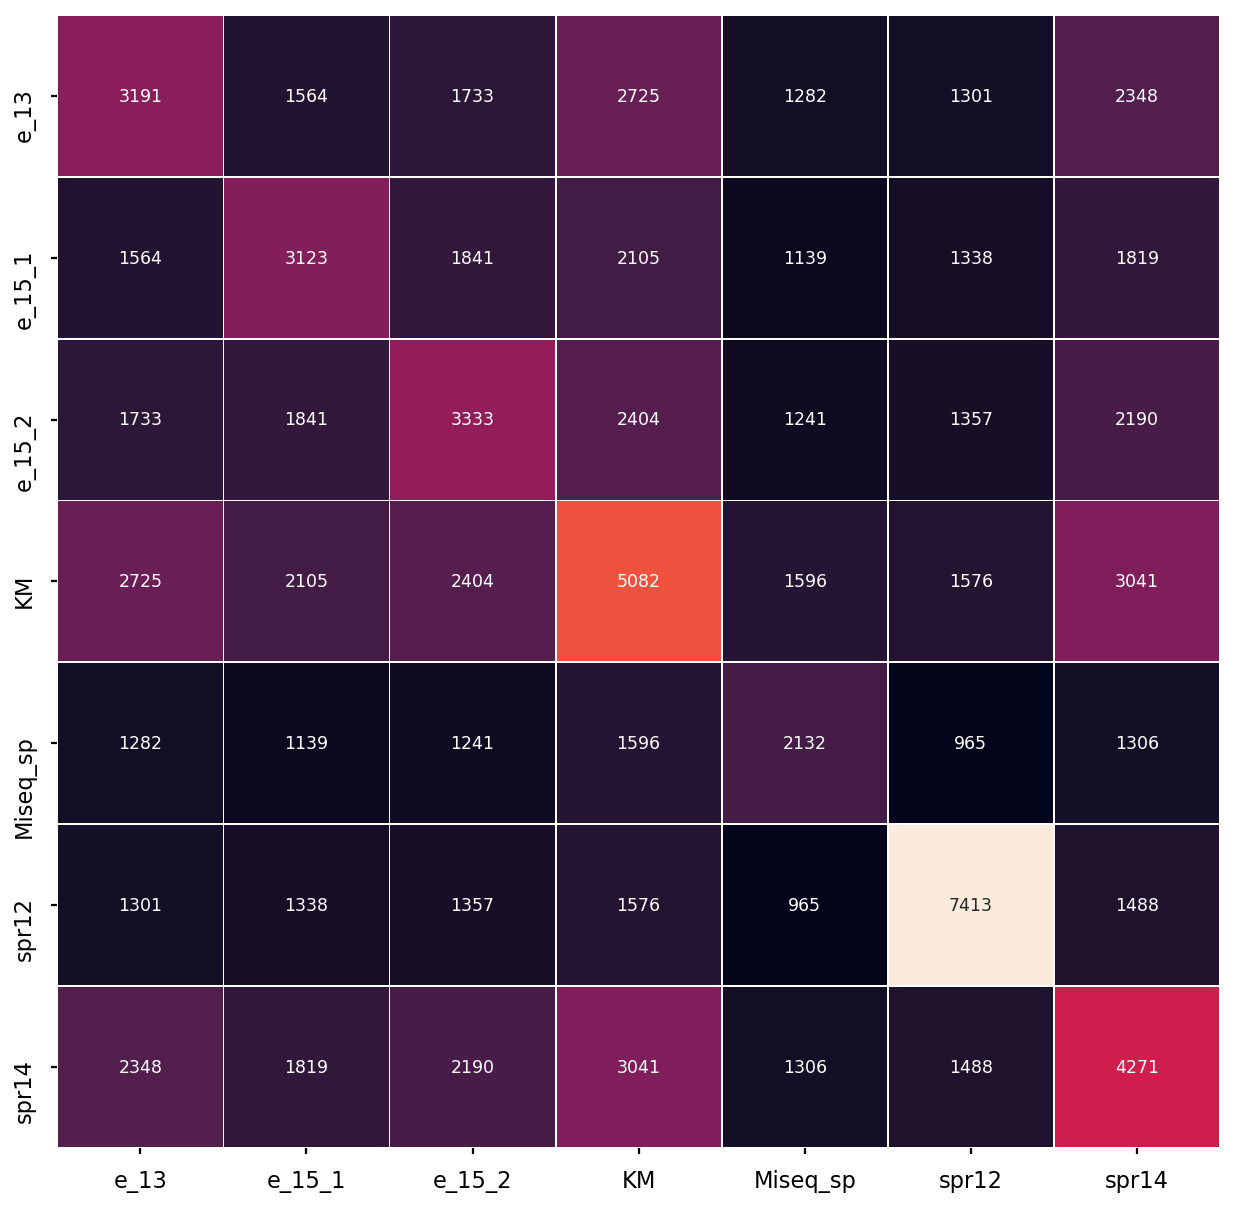

In [72]:
onlycb33 = meta_data_df2.loc[abund_df_og.index, 'StationName'] == 'CB33C'
adf = abund_df_og.loc[onlycb33, :]
mdf = meta_data_df2.loc[adf.index, :]
runs_to_keep = meta_data_df2.loc[adf.index, 'sequencing_ID'].unique()
shared_otus = pd.DataFrame(index=runs_to_keep, columns=runs_to_keep)
shared_group = set(adf.columns)

for run_grp1 in shared_otus.columns:
    rg1_bool = mdf.sequencing_ID == run_grp1
    print("{} has {} libraries".format(run_grp1, rg1_bool.sum()))
    for run_grp2 in shared_otus.index:
        rg2_bool = mdf.sequencing_ID == run_grp2
        otus_in_1 = adf.loc[rg1_bool, :].sum() / rg1_bool.sum()
        otus_in_2 = adf.loc[rg2_bool, :].sum() / rg2_bool.sum()
        foldchange = otus_in_1 / otus_in_2
        num_shared = ((foldchange < 1000) & (foldchange > 0.001)).sum()
        shared_otus.loc[run_grp2, run_grp1] = num_shared
        # optional shared across all groups
        shared_here = foldchange.index[(foldchange < 1000) & (foldchange > 0.001)]
        shared_group = shared_group.intersection(set(shared_here))

print("{} otus shared across all runs".format(len(shared_group)))


plt.clf(); plt.close();
f, _axes_ = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), dpi=125)
sns.heatmap(shared_otus, annot=True, fmt="d", linewidths=.5, ax=_axes_, cbar=False)
plt.savefig("../otu_data/OTU_Overlap_CB33_byRun.png", bbox_inches='tight')
plt.show()
plt.clf(); plt.close();


# Load or make rarefied OTU table & calculate alpha diversity w/bootstraps

In [73]:
from skbio.stats import subsample_counts
from skbio.diversity.alpha import enspie, observed_otus

# need to do rarefaction here
alpha_fn = "../otu_data/alpha_metrics.tsv"
rare_fn = "../otu_data/rarefied_table.tsv"
if os.path.exists(alpha_fn) and os.path.exists(rare_fn):
    alpha_df = pd.read_csv(alpha_fn, sep="\t", index_col=0)
    rare_abund = pd.read_csv(rare_fn, sep="\t", index_col=0)
else:
    print("Calculating alpha diversity metrics and rarefaction table")
    alpha_cols = ['enspie', 'enspie_25', 'enspie_975', 'observed_otus', 'observed_otus_25', 'observed_otus_975']
    alpha_metrics = pd.DataFrame(index=abund_df_og.index, columns=alpha_cols).astype(float)
    rare_abund = abund_df_og * 0.
    total_abunds = abund_df_og.sum(1)
    rare_level = 3001
    for samp in abund_df_og.index:
        enspies, simpson_es, obs_otuses = np.array([0.0]*1000), np.array([0.0]*1000), np.array([0.0]*1000)
        for i in range(1000):
            norm_factor = 1.0
            if total_abunds[samp] < rare_level:
                norm_factor = rare_level / total_abunds[samp]
            
            select_vect = np.ceil(abund_df_og.loc[samp, :].values*norm_factor).astype(np.int64)
            rare_vect = subsample_counts(select_vect, int(rare_level))
            rare_abund.loc[samp, :] = rare_vect
            enspies[i] = enspie(rare_abund.loc[samp, :].values)
            obs_otuses[i] = observed_otus(rare_abund.loc[samp, :].values)
        
        enspies.sort(); obs_otuses.sort();
        for met_name, met_vec in zip(['enspie', "observed_otus"], [enspies, obs_otuses]):
            met_pctiles = np.percentile(met_vec, [2.5, 50, 97.5])
            alpha_metrics.loc[samp, met_name] = met_pctiles[1]
            alpha_metrics.loc[samp, met_name+'_25'] = met_pctiles[1] - met_pctiles[0]
            alpha_metrics.loc[samp, met_name+'_975'] = met_pctiles[2] - met_pctiles[1]
    
    alpha_metrics.to_csv(alpha_fn, sep="\t")
    rare_abund.to_csv(rare_fn, sep="\t")
    alpha_df = alpha_metrics.copy()


Calculating alpha diversity metrics and rarefaction table


In [ ]:
melted_file = "../otu_data/WaterQualityData/melted_wq_07to17.tsv"
if not os.path.exists(melted_file):
    db_file = "../otu_data/WaterQualityData/WaterQualityData_07to17.tsv"
    df_raw = pd.read_csv(db_file, sep="\t", parse_dates=[['SampleDate', 'SampleTime']], low_memory=False)
    df_nn = df_raw[df_raw.MeasureValue.notnull()]
    df_nn['SampleDate_SampleTime'] = df_nn.SampleDate_SampleTime.apply(pd.to_datetime)
    summer_idxs = set()
    for yr_i, yr in enumerate(range(2012,2018)):
        left_side = pd.to_datetime(str(yr)+'-03-15')
        right_side = pd.to_datetime(str(yr)+'-10-15')
        date_range_ = (df_nn.SampleDate_SampleTime >= left_side) & (df_nn.SampleDate_SampleTime < right_side)
        summer_idxs.update(df_nn[date_range_].index)
        print("Window {} is {} to {}, grabbed {} total".format(yr_i, left_side, right_side, len(summer_idxs)))

    df_nv = df_nn.loc[summer_idxs, :]
    df_nv.loc[df_nv.Problem == 'NV', 'Problem'] = np.nan
    df_nv.loc[df_nv.Problem == 'QQ', 'Problem'] = np.nan
    df_nv.loc[df_nv.Problem == 'WW', 'Problem'] = np.nan
    df_np = df_nv[df_nv.Problem.isnull()]

    needed_cols = ['TotalDepth', 'UpperPycnocline', 'LowerPycnocline']
    idx_cols = ["SampleDate_SampleTime", "Station", "Depth"]
    new_df = pd.pivot_table(data = df_np, index = idx_cols, columns = 'Parameter', 
                            values = 'MeasureValue', aggfunc=np.mean).sort_index()

    addl_cols = df_np.loc[:, idx_cols+needed_cols].groupby(idx_cols).agg(np.mean).sort_index()
    wq_melted = new_df.join(addl_cols)
    wq_melted.to_csv(melted_file, sep="\t")
else:
    wq_melted_df = pd.read_csv(melted_file, sep="\t", index_col=[0,1,2])

The collapsed taxa table is (393, 41)
41 colors grabbed


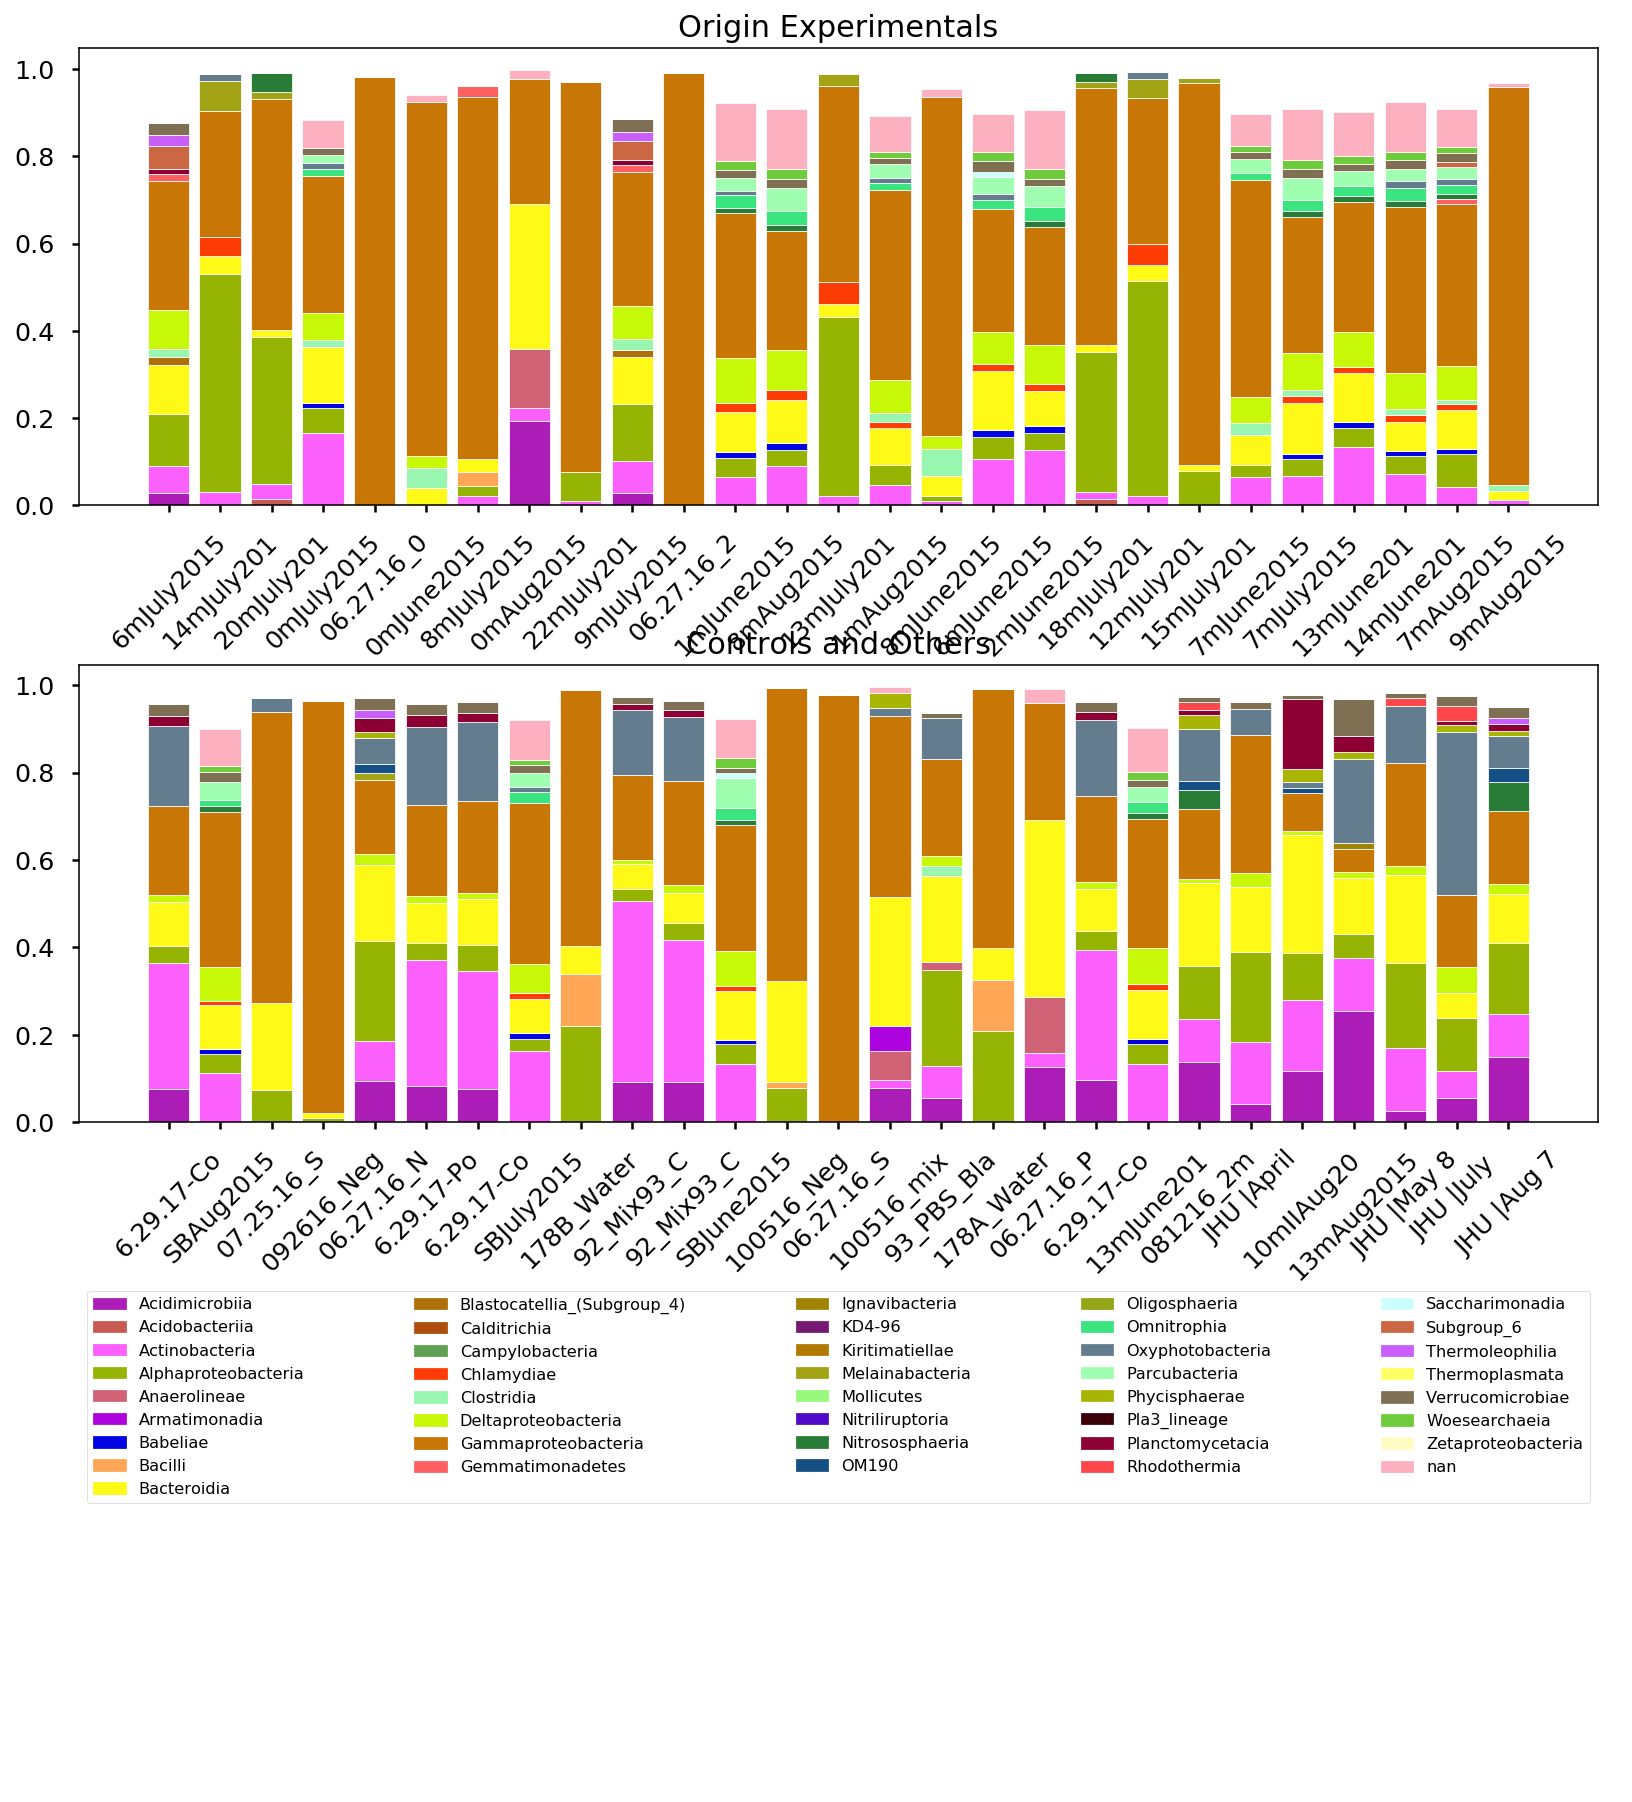

Saving Taxa_Plot_2015_Samples.png


In [40]:

def taxa_breakdown(abunds_, taxas_, level_, weighted=True, flatten_val=0.0):
    # 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'
    # remove non-existant features
    flip_abunds = abunds_.loc[:, abunds_.sum(0) > 0].T
    # create presence or absence table if need be
    if not weighted:
        flip_abunds = (flip_abunds > 0).astype(int)
    # add level column
    otu_fetch = lambda x: taxas_.loc[x, level_]
    flip_abunds['otu_name'] = flip_abunds.index
    flip_abunds['taxa_name'] = flip_abunds['otu_name'].apply(otu_fetch)
    flip_abunds.drop('otu_name', axis=1, inplace=True)
    ttable_raw = flip_abunds.groupby('taxa_name').agg(np.sum)
    ttable = ttable_raw.div(ttable_raw.sum(0))
    if flatten_val:
        flat_ttv = ttable.values
        flat_ttv[flat_ttv < flatten_val] = 0.0
        ttable = pd.DataFrame(flat_ttv, index=ttable.index, columns=ttable.columns)
    return ttable.T

non_origin = control_libs_plus
super_group = non_origin + list(non_control_oc)

abunds_1 = abund_df_og.copy()
taxas_1 = taxa_df.copy().astype(str)
level_1 = 'Class'

ttable_1 = taxa_breakdown(abunds_1, taxas_1, level_1, weighted=True, flatten_val=0.01)
ttable_1 = ttable_1.loc[:, ttable_1.columns[ttable_1.sum() > 0]]
print("The collapsed taxa table is {}".format(ttable_1.shape))

ttable_origin = ttable_1.loc[non_control_oc, :]
ttable_nonorigin = ttable_1.loc[non_origin, :]

fignamet = "Taxa_Plot_2015_Samples.png"
figpatht = os.path.join("../otu_data/pca_plots", fignamet)

plt.clf(); plt.close();
fig_width = 14
fig_t, ax_arr = plt.subplots(nrows=3, ncols=1, figsize=(fig_width,16), dpi=140)
possible_colors = [j for i, j in sns.xkcd_rgb.items() if not 'white' in i]
np.random.seed(1)
colors_needed = np.random.choice(possible_colors, size=ttable_1.columns.shape)
print("{} colors grabbed".format(len(colors_needed)))

# loop over each table to plot
axis_titles = ['Origin Experimentals', 'Controls and Others']
for ax_ix, table_x in enumerate([ttable_origin, ttable_nonorigin]):
    # pick an axis
    ax_i = ax_arr[ax_ix]
    ax_i.set_title(axis_titles[ax_ix])
    # set the width of each bar to the number of samples
    adjusted_width = (fig_width / table_x.shape[0])*(.8)
    # set the left bottom anchor of each bar
    bar_locs = np.arange(table_x.shape[0])*(fig_width / table_x.shape[0])
    # set the bar labels (TODO)
    bar_names = [meta_data_df2.loc[i, 'Short sample name'][:10] for i in table_x.index]
    # loop over each taxon name
    for bar_n, bar_col in enumerate(table_x.columns):
        # subset those fractions across samples
        bar_x = table_x.loc[:, bar_col]
        # set the y-axis location for each bar
        if bar_n == 0:
            running_base = bar_x*0.0
        # Create an individual bar
        ax_i.bar(bar_locs, bar_x.values, bottom=running_base.values, 
                 color=colors_needed[bar_n], edgecolor='white', 
                 width=adjusted_width, tick_label=bar_names)
        for tick in ax_i.get_xticklabels():
            tick.set_rotation(45)
        # increment the bottoms
        running_base = running_base + bar_x

patches = [mpatches.Patch(color=color, label=label) for label, color in zip(list(ttable_1.columns), colors_needed)]
ax_arr[2].legend(patches, list(ttable_1.columns), 
                 loc='best', bbox_to_anchor=(0., 0., 1., 1.),
                 mode='expand', fontsize='small', ncol=5)

ax_arr[2].axis('off')
plt.subplots_adjust(hspace=.35)
# Show graphic
plt.show()
print("Saving {}".format(fignamet))
fig_t.savefig(figpatht, dpi=140)
plt.clf(); plt.close();


In [ ]:





import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from itertools import product
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr


from skbio.stats.distance import permanova
from skbio.stats.distance import permdisp
from scipy.cluster import hierarchy
from matplotlib.colors import LinearSegmentedColormap
import matplotlib


### Load metadata and filter out OTUs w/ >50% total abundance in blanks

# Check effect of rarefaction

In [ ]:
super_df = pd.concat([alpha_df, meta_df_nocodes.loc[alpha_df.index, :]], axis=1)
super_exp = super_df[(super_df.station != 'LAB') & (super_df.depth != 'Control') & (super_df.depth != 'nan')]
super_exp.loc[super_exp.depth == 'Surface', 'depth'] = '01'
super_exp.depth = super_exp.depth.apply(lambda x: "0"+x if len(x) == 1 else x)
super_sorted = super_exp.sort_values(['year', 'month', 'lat', 'depth' ], ascending=[True, True, False, True])
super_sorted['month_year'] = super_sorted.loc[:, ['month', 'year']].apply(lambda x: " ".join(x), axis=1)
super_sorted['salinity_group'] = pd.Series([""]*super_sorted.index.shape[0], index=super_sorted.index)

oos_before = abund_df.apply(observed_otus, axis=1) 
oos_after = rare_abund.apply(observed_otus, axis=1)
print("Spearman correleations between trimmed read count and observed otus before rarefaction")
print(spearmanr(oos_before.loc[super_sorted.index].values, super_sorted.TrimCount.values))
print("Spearman correleations between trimmed read count and observed otus after rarefaction")
print(spearmanr(oos_after.loc[super_sorted.index].values, super_sorted.TrimCount.values))
print("Spearman correleations between trimmed read count and ENSPIE after rarefaction")
print(spearmanr(super_sorted.enspie.values, super_sorted.TrimCount.values))

# Get actual pycnocline locations

In [ ]:
def date1(x):
    a = [float(i) for i in x.split()[0].split("-")]
    return a[0] + a[1]/12 + a[2]/(365)

def date2(a):
    return float(a[:2])/(12) + float(a[2:4])/(30*12) + (float(a[4:])+2000)

water_quals = pd.read_csv('/Volumes/KeithSSD/ChesBayTransect/data/WaterQualityData/melted_wq_df.tsv', sep="\t")
water_quals['date_float'] = water_quals['Time'].apply(date1)
isint = lambda x: True if x%1.0 == 0 else False
water_nzd = water_quals[(water_quals.Depth != 0) & water_quals.Depth.apply(isint)]
super_sorted['date_float'] = super_sorted['date'].apply(date2)


# match it up 
pycnocline_d, max_bvf = {}, {}
for i, i_i in enumerate(super_sorted.index):
    stat_i, dfl_i = super_sorted.loc[i_i, ['station', 'date_float']]
    if (stat_i, dfl_i) not in pycnocline_d.keys():
        stat_i2 = stat_i[:3] + "." + stat_i[3:]
        sub_wq = water_nzd[water_nzd.Station == stat_i2]
        done_bool = False
        date_avail = sorted(sub_wq.date_float.unique())
        while not done_bool:
            date_resids = abs(date_avail - dfl_i)
            closest = date_avail[np.argmin(date_resids)]
            subsub_wq = sub_wq[sub_wq.date_float == closest].sort_values(['Depth']).loc[:, ['Depth', 'SIGMA_T']]
            subsub_wq['BVF'] = pd.Series(np.gradient(subsub_wq.SIGMA_T.values, subsub_wq.Depth.values), index=subsub_wq.index)
            subsub_wq2 = subsub_wq[subsub_wq.Depth > 2.0]
            if subsub_wq2.BVF.isnull().sum() > subsub_wq2.shape[0]/3:
                print("bad date")
                date_avail = np.delete(date_avail, np.where(date_avail == closest))
            else:
                done_bool = True
                pycnocline_d[(stat_i, dfl_i)] = subsub_wq2.loc[subsub_wq2['BVF'].idxmax(), 'Depth']
                max_bvf[(stat_i, dfl_i)] = subsub_wq2.loc[subsub_wq2['BVF'].idxmax(), 'BVF']

print("done")
super_sorted['pycnocline'] = super_sorted.loc[:, ['depth', 'station', 'date_float']].apply(lambda x: 'Above' if int(x[0]) < pycnocline_d[(x[1], x[2])] else 'Below', axis=1)
super_sorted['dsigma_dm'] = super_sorted.loc[:, ['station', 'date_float']].apply(lambda x: max_bvf[(x[0], x[1])], axis=1)
super_sorted['pycnocline_depth'] = super_sorted.loc[:, ['station', 'date_float']].apply(lambda x: pycnocline_d[(x[0], x[1])], axis=1)


# Look at results of density gradient calculations 

In [ ]:
#print(super_sorted.loc[:, ['station', 'month', 'dsigma_dm', 'pycnocline_depth']].groupby(['station','month']).mean().sort_index().iloc[:31, :])
#print(super_sorted.loc[:, ['station', 'month', 'dsigma_dm', 'pycnocline_depth']].groupby(['station','month']).mean().sort_index().iloc[31:61, :])
#print(super_sorted.loc[:, ['station', 'month', 'dsigma_dm', 'pycnocline_depth']].groupby(['station','month']).mean().sort_index().iloc[61:91, :])
#print(super_sorted.loc[:, ['station', 'month', 'dsigma_dm', 'pycnocline_depth']].groupby(['station','month']).mean().sort_index().iloc[91:, :])
super_sorted.plot.scatter(x='observed_otus', y='dsigma_dm', s=50);

# add all the rest of the sample data

In [ ]:
sub_ss = sample_sheet[sample_sheet.SampleID.isin(super_sorted.index)].set_index('SampleID')
sub_ss.columns = [i.lower().replace(" ", "_")+"_" for i in sub_ss.columns]
meta_extra = pd.concat([super_sorted, sub_ss], axis=1)
for xx in ['sampling_notes_', 'short_sample_name_', 'stationname_', 'datemmddyy_']:
    meta_extra[xx] = meta_extra[xx].astype(str)

meta_extra.loc['95_FiltCtrl_Surface_R1', 'sampling_notes_' ] = 'ODU'
meta_extra['replicate'] = pd.Series([1]*meta_extra.shape[0], index=meta_extra.index)
meta_extra['_tds_'] = meta_extra.loc[:, ['date', 'depth', 'station']].apply(tuple, axis=1)

for (t_, d_, s_) in meta_extra._tds_.unique():
    mxO = meta_extra[meta_extra['_tds_'] == (t_, d_, s_)].index
    if len(mxO) != 1:
        for num_r, ix_ in enumerate(mxO):
            if num_r != 0:
                assert ix_ in meta_extra.index
                meta_extra.loc[ix_, 'replicate'] = num_r+1
        
mx_derep = meta_extra[meta_extra.replicate == 1]
print(mx_derep.shape, meta_extra.shape)

odu_bool = mx_derep.short_sample_name_.str.contains('ODU')
odu_bool2 = mx_derep.sampling_notes_.str.contains('ODU')
print("# ODU samples: {}".format((odu_bool | odu_bool2).sum()))

mx1 = mx_derep[~odu_bool & ~odu_bool2]
dnr_bool = mx1.short_sample_name_.str.contains('DNR')
dnr_bool2 = mx1.sampling_notes_.str.contains('DNR')
mx2 = mx1[~dnr_bool & ~dnr_bool2]
print("# DNR samples: {}".format((dnr_bool | dnr_bool2).sum()))
rest_cb33 = mx2.stationname_ == 'CB33C'
print("Remaining samples taken from CB33C (our lab): {}".format(rest_cb33.sum()))
print("Left to classify: {}".format(mx_derep.shape[0] -(114+108+105)))

#meta_extra3 = mx2[~(mx2.stationname_ == 'CB33C')]
#print(meta_extra3.iloc[:, 20:40])
control_libs_ = ['178A_WaterBathControlA', '178B_WaterBathControlB']
control_libs_ += list(abund_df5.index[abund_df5.index.str.contains("Blank")])
control_libs_ += list(abund_df5.index[abund_df5.index.str.contains("Zymo")])
control_libs_ += list(abund_df5.index[abund_df5.index.str.contains("Mix9")])
control_libs_ += list(abund_df5.index[abund_df5.index.str.contains("CDSBBR")])
print("# controls removed: {} ".format(len(control_libs_)))
      
print((meta_extra.year == '2015').sum())

# Alpha Diversity Summary Statistics

In [ ]:
sal_dict = {"oligohaline": ['CB22', 'CB31'],
            "mesohaline": ['CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54'],
            "polyhaline": ['CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']}

for sal_i, stat_ls in sal_dict.items():
    super_sorted.loc[super_sorted.station.isin(stat_ls), 'salinity_group'] = sal_i

transect_data = super_sorted[super_sorted.station != 'CB33C']
cb_33_data = super_sorted[super_sorted.station == 'CB33C']

no_outliers = super_sorted[~super_sorted.index.isin(['SB072215TAWCSCB33CD9BR1TR1I36', 'SB072215TAWCSCB33CD6BR1TR1I33'])]
for vargrp in ['year', 'month', 'month_year', 'pycnocline', 'salinity_group']:
    print(vargrp);
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).mean().sort_index())
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).std().sort_index())
    print(super_sorted.loc[:, ['enspie', 'observed_otus', vargrp]].groupby([vargrp]).count().sort_index())


# Panel 1 of Alpha Diversity Figure (1): CB33C Data

In [ ]:
xmax1 = (cb_33_data.enspie.max()+cb_33_data.enspie_975.max())*1.1
xmax2 = (cb_33_data.observed_otus.max()+cb_33_data.observed_otus_975.max())*1.1
plt.clf()
fig, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(8.5,11), dpi=250)
height_ = 0.45
fig.text(0.5, 0.06, 'Effective Number of Species (ENSPIE)', ha='center')
fig.text(0.5, 0.94, "Observed OTUs", ha='center')
for ar_, yr_ in enumerate(cb_33_data.year.unique()):
    sub_df_pre = cb_33_data[cb_33_data.year == yr_].copy().sort_values(['date_float', 'depth'], ascending=False)
    sub_df = sub_df_pre.reset_index()
    y_reverse = sub_df.index.values #(sub_df.index.values - max(sub_df.index.values))*-1
    labs =  sub_df.loc[:, ['month', 'depth']].apply(lambda x: x[0]+" "+x[1]+"m", axis=1)
    ax_arr[ar_].set_title(yr_)
    ax_arr[ar_].barh(y=y_reverse-height_, width=sub_df.loc[y_reverse, 'enspie'].values, height=height_,
                     xerr=sub_df.loc[:, ['enspie_25', 'enspie_975']].values.T,  color="#FF1493",
                     tick_label=labs.values, label="ENSPIE")
    ax_arr[ar_].set_ylim([ax_arr[ar_].get_ylim()[0]+1.8, ax_arr[ar_].get_ylim()[1]-1.8])
    ax_arr[ar_].set_xlim([0., xmax1])
    ax_arr[ar_].set_facecolor('#DCDCDC')
    ar_2 = ax_arr[ar_].twiny()
    ar_2.barh(y=y_reverse, width=sub_df.loc[y_reverse, 'observed_otus'].values,
              xerr=sub_df.loc[:, ['observed_otus_25', 'observed_otus_975']].values.T, 
              color="#00BFFF", height=height_, label="Observed OTUs")
    ar_2.set_xlim([0., xmax2])

    ar_2.grid(b=True, which='both', axis='x', color="#000000")
    if ar_ == 0:
        fig.legend(loc='lower center')

fig.subplots_adjust(wspace=0.4)
fig.savefig("../data/otu_data_pca/alpha_scatter_cb33.png")
plt.show()

# Panel 2 of Alpha Diveristy Figure (1): Transect Data

In [ ]:
face_colors = {'mesohaline':'#DCDCDC',
               'oligohaline':'#FFFFFF',
               'polyhaline':'#A9A9A9'}
t_col_1 = ['CB22', 'CB31', 'CB32', 'CB41C', 'CB42C', 'CB43C', 'CB44']
t_col_2 = ['CB51', 'CB52', 'CB53', 'CB54', 'CB61', 'CB62']
t_col_3 = ['CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74']

height_2 = 0.3
xmaxt1 = (transect_data.enspie.max()+transect_data.enspie_975.max())*1.1
xmaxt2 = (transect_data.simpson_e.max()+transect_data.simpson_e_975.max())*1.1

for col_nstr, stat_grp in enumerate([t_col_1, t_col_2, t_col_3]):
    plt.clf()
    subdf = transect_data[transect_data.station.isin(stat_grp)]
    hrs = [subdf[subdf.station == i].shape[0] for i in stat_grp]
    if col_nstr == 2:
        hrs.append(hrs[-1])
    
    fig2 = plt.figure(constrained_layout=True, figsize=(2.83,11), dpi=250)
    gs = gridspec.GridSpec(len(hrs), 1, height_ratios=hrs, figure=fig2)
    
    for facet in range(gs._nrows):
        if (col_nstr == 2) and (facet == (gs._nrows-1)):
            facax = plt.subplot(gs[facet])
            facax.axis('off')
        else:
            this_stat = stat_grp[facet]
            subdubdf_pre = subdf.loc[subdf.station == this_stat].copy().sort_values(['depth', 'date_float'], ascending=False)
            subdubdf = subdubdf_pre.reset_index()
            y_pos = subdubdf.index.values
            labs =  subdubdf.loc[:, ['month', 'depth', 'year']].apply(lambda x: x[0]+"/"+x[2][-2:]+" "+x[1]+"m", axis=1)
            facax = plt.subplot(gs[facet])
            facax.set_facecolor(face_colors[subdubdf.salinity_group.values[0]])
            facax.barh(y=y_pos-height_2, width=subdubdf.loc[:, 'enspie'].values, height=height_2,
                       xerr=subdubdf.loc[:, ['enspie_25', 'enspie_975']].values.T,  color="#FF1493",
                       tick_label=labs.values, label="ENSPIE")
            facax.set_xlim([0., xmaxt1])
            facax_2 = facax.twiny()
            facax_2.barh(y=y_pos, width=subdubdf.loc[:, 'observed_otus'].values,
                         xerr=subdubdf.loc[:, ['observed_otus_25', 'observed_otus_975']].values.T, 
                         color="#00BFFF", height=height_2, label="Observed OTUs")
            facax_2.set_xlim([0., xmax2])
            facax_2.grid(b=True, which='both', axis='x', color="#000000")
            facax_2.add_artist(AnchoredText(this_stat, borderpad=0., prop=dict(size=12), frameon=False, loc='center right'))
            
            if facet != (gs._nrows - 1) and (col_nstr != 2):
                # the bottom one only retains the enspie labels
                facax.set_xticklabels([])
            elif facet != (gs._nrows - 2) and (col_nstr == 2):
                facax.set_xticklabels([])
            elif facet == (gs._nrows - 1) and (col_nstr == 1):
                facax.set_xlabel('Effective # of Sp. (ENSPIE)')
            
            if facet != 0:
                # the top one only has simpsons labels
                facax_2.set_xticklabels([])
            elif (facet == 0) and (col_nstr == 1):
                facax_2.set_xlabel('Observed OTUs')
            
            if this_stat == 'CB63':
                fig2.legend(loc='lower center')
    
    fig2.savefig("../data/otu_data_pca/alpha_scatter_transect_{}.png".format(col_nstr), dpi=250)

plt.clf(); plt.close();

fig3 = plt.figure(figsize=(8.5, 11), dpi=250)
for i in range(3):
    img=mpimg.imread("../data/otu_data_pca/alpha_scatter_transect_{}.png".format(i))
    sub = fig3.add_subplot(1, 3, i + 1)
    sub.axis('off')
    sub.imshow(img)

fig3.tight_layout()
fig3.subplots_adjust(wspace=0)
fig3.savefig("../data/otu_data_pca/alpha_scatter_transect.png", dpi=250)
plt.show()


# Figure 2: Hierarchical Clustering of Principal Components w/ Metadata 

In [ ]:
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering

exp_abunds = abund_df.loc[super_sorted.index, :]
rclr_mat = rclr().fit_transform(exp_abunds.values + 0.00001)
# alternative https://github.com/skinnider/dismay *proportionality
# the componenets was picked based on the point where the number of clusters formed was the most stable. 
model = PCA(n_components=27, svd_solver='randomized', random_state=42)
model.fit(rclr_mat)
projected = model.fit_transform(rclr_mat)
pc_df = pd.DataFrame(index=exp_abunds.index, data=projected)

ch_scores, ss_scores = [], []
for n_clusters_ in range(3,15):
    cluster_mod = AgglomerativeClustering(n_clusters=n_clusters_, affinity='euclidean', linkage='ward') 
    cluster_labels = cluster_mod.fit_predict(projected)
    ch_score = metrics.calinski_harabaz_score(projected, cluster_labels)
    ss_score = metrics.silhouette_score(projected, cluster_labels)
    ch_scores.append(ch_score)
    ss_scores.append(ss_score)

score_srs = pd.DataFrame(data=np.array([ch_scores, ss_scores]).T, index=list(range(3,15)), columns=['CH', "Silhouette"])
#score_srs.CH.plot()
#score_srs.Silhouette.plot(secondary_y=True, style='g')
print("Optimal number of clusters is {} / {}".format(score_srs.CH.idxmax(), score_srs.Silhouette.idxmax()))

opt_clusts = 7
plt.clf()
# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 0.5
Z = hierarchy.linkage(pc_df, 'ward', optimal_ordering=True)
fig_ = plt.figure(figsize=(7, 6), dpi=250)
gs = gridspec.GridSpec(4, 4, figure=fig_, wspace=0.01, hspace=0.01, height_ratios=[4,.4,.4,.4], width_ratios=[18,.4,1.3,1.3])
ax1 = plt.subplot(gs[0,0])

for c_height in np.arange(400,1500, 5):
    cuttree = hierarchy.cut_tree(Z, height=[c_height])
    if len(set(list(cuttree[:, 0]))) <= opt_clusts:
        break

print(len(set(list(cuttree[:, 0]))))

print("optimal minimum cophenetic distance is {}".format(c_height))
hierarchy.set_link_color_palette(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
                                  'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
                                  'tab:olive', 'tab:cyan'])
res = hierarchy.dendrogram(Z, color_threshold=c_height+50, get_leaves=True, ax=ax1, labels=pc_df.index, no_labels=True, above_threshold_color='k')
ax1.axhline(y=c_height+50)
ax1.axis('off')
matplotlib.rcParams['lines.linewidth'] = 1.5


"""
clustered_ = hierarchy.fclusterdata(projected, c_height, criterion='distance', method='ward', metric='euclidean')

# look for lines that cross the c_height mark, collect their index, find their corresponding x position 
crosses_ = []
for horse_i, (horseshoe_x, horseshoe_y) in enumerate(zip(res['icoord'], res['dcoord'])):
    l_1b, l_1t, l_2t, l_2b = horseshoe_y
    if (l_1b < c_height) and (l_1t > c_height):
        crosses_.append((horse_i, horseshoe_x[0]))
    if (l_2b < c_height) and (l_2t > c_height):
        crosses_.append((horse_i, horseshoe_x[2]))
    
sorted_crossings = sorted(crosses_, key=lambda x: x[1])

relative_position = []
for n in list(set(list(clustered_))):
    y_axis_in_dendro = np.arange(clustered_.shape[0])[clustered_ == n]
    relative_position.append((n, np.median(y_axis_in_dendro)))
    
sorted_positions = sorted(relative_position, key=lambda x: x[1])
for (h_i, h_x), (n_i, rp_i) in zip(sorted_crossings, sorted_positions):
    ax1.text(h_x,c_height+5.,str(n_i),fontdict={'fontsize':6})
"""

# get axis order
new_idx = pc_df.index[res['leaves']]
# metadata columns to plot
sel_md_cols = ['month_year', 'station', 'pycnocline', 'salinity_group', 'run']
# resort metadata
clustered_metadata = super_sorted.loc[new_idx, sel_md_cols].copy()
# encode colors and reverse
color_codings = [{1:'06 2015', 2:'07 2015', 3:'08 2015', 7:'06 2016', 8:'07 2016', 9:'08 2016', 13:'04 2017', 14:'05 2017', 15:'06 2017', 16:'07 2017', 17:'08 2017', 20:'09 2017'},
                 {4:'CB33C', 1:'CB22', 5:'CB41C', 7:'CB43C', 8:'CB44', 9:'CB51', 10:'CB52', 11:'CB53', 12:'CB54', 17:'CB71', 14:'CB62', 15:'CB63', 18:'CB72', 16:'CB64', 20:'CB74', 2:'CB31', 3:'CB32', 6:'CB42C', 13:'CB61', 19:'CB73'},
                 {1:'Above', 20:'Below'}, {10:'mesohaline', 1:'oligohaline', 20:'polyhaline'},
                 {1:'sprehei1_123382', 4:'Miseq_data_SarahPreheim_Sept2016', 7:'esakows1_132789', 10:'Keith_Maeve1_138650', 13:'sprehei1_149186', 17:'esakows1_152133_plate_1', 20:'esakows1_152133_plate_2'}]
rev_col_codes = []
for x in color_codings:
    rev_col_codes.append({j:i for i, j in x.items()})

# map encodings
for sdc, cmapping in zip(sel_md_cols, rev_col_codes):
    clustered_metadata[sdc] = clustered_metadata[sdc].map(cmapping)

# select palette with max # of categories
all_col_pal = sns.color_palette("cubehelix_r", clustered_metadata.max().max())
cmap_ = LinearSegmentedColormap.from_list('Custom', tuple(all_col_pal), len(tuple(all_col_pal)))

# plot first row and bar
ax2 = plt.subplot(gs[1,0])
ax2l = plt.subplot(gs[1,1:])
ax2l.text(0.,0.4, "Sampling Date", fontdict={'fontsize':6})
ax2.axis('off'); ax2l.axis('off');
ax2_vals = clustered_metadata[sel_md_cols[0]].values.reshape(372,1).T
sns.heatmap(ax2_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax2)

ax4 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[0,1])
ax4_vals = clustered_metadata[sel_md_cols[1]].values.reshape(372,1).T
stat_ax = sns.heatmap(ax4_vals, linewidths=0.0, cmap=cmap_, cbar=True, cbar_ax=ax3, xticklabels=False, yticklabels=False, ax=ax4)
cb = stat_ax.collections[0].colorbar
cb.ax.tick_params(labelsize=6);
cb.set_ticks([1, 20]); cb.set_ticklabels(['Min', 'Max']); 
ax4l = plt.subplot(gs[2,1:])
ax4l.text(0.,0.4, "Station", fontdict={'fontsize':6})
ax4.axis('off'); ax4l.axis('off');
"""
ax5 = plt.subplot(gs[3,0])
ax5_vals = clustered_metadata[sel_md_cols[2]].values.reshape(372,1).T
sns.heatmap(ax5_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax5)
ax5l = plt.subplot(gs[3,1:])
ax5l.text(0.,0.4, "Pycnocline", fontdict={'fontsize':6})
ax5.axis('off'); ax5l.axis('off');
"""
ax6 = plt.subplot(gs[3,0])
ax6_vals = clustered_metadata[sel_md_cols[3]].values.reshape(372,1).T
sns.heatmap(ax6_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax6)
ax6l = plt.subplot(gs[3,1:])
ax6l.text(0.,0.4, "Salinity Region", fontdict={'fontsize':6})
ax6.axis('off'); ax6l.axis('off');
"""
ax7 = plt.subplot(gs[5,0])
ax7_vals = clustered_metadata[sel_md_cols[4]].values.reshape(372,1).T
sns.heatmap(ax7_vals, linewidths=0.0, cmap=cmap_, cbar=False, xticklabels=False, yticklabels=False, ax=ax7)
ax7l = plt.subplot(gs[5,1:])
ax7l.text(0.,0.4, "Sequencing Run", fontdict={'fontsize':6})
ax7.axis('off'); ax7l.axis('off');
"""
fig_.savefig('../data/otu_data_pca/pca_of_rclr_ward_clustermap.png', dpi=250)


# Extract interesting subclusters

In [ ]:
clustered_ = hierarchy.fclusterdata(projected, c_height, criterion='distance', method='ward', metric='euclidean')
clust_cols = ['nMonths', 'nYears', 'nStations', 'nDates', 'nPyc']
clust_cols += ['nMonths_noCB33', 'nYears_noCB33', 'nStations_noCB33', 'nDates_noCB33', 'nPyc_noCB33']

cluster_stats = pd.DataFrame(index=list(set(list(clustered_))), columns = clust_cols)

bottom_only = ['CB22', 'CB31', 'CB32', 'CB52', 'CB51', 'CB43C', 'CB42C', 'CB41C']

for x in set(list(clustered_)):
    mixed_clust = super_sorted.index[clustered_ == x]
    subdf = super_sorted.loc[mixed_clust, :]
    num_samps = mixed_clust.shape[0]
    print("Cluster {} with {} samps".format(x, num_samps))
    print(subdf.enspie.mean(), subdf.enspie.std())
    print(subdf.loc[subdf.station.isin(['CB71','CB72', 'CB63', 'CB61', 'CB62', 'CB22']), ['station', 'month_year']])
#    for col_s in ['station', 'year', 'month_year', 'pycnocline', 'month']:
#    for col_s in ['station']:
#        n_x, x_x = np.unique(subdf[col_s].values, return_counts=1)
#        for n, x in zip(n_x, x_x):
#            print("\t{}: {:.2%}".format(n, x/num_samps))
#        input()




# Checking for significant covariates that obey homogeniety of variance assumptions

In [ ]:
rare_abund2 = rare_abund.loc[super_sorted.index, rare_abund.columns[rare_abund.sum(0) > 0]]
exp_abunds2 = exp_abunds.loc[:, exp_abunds.columns[exp_abunds.sum(0) > 0]]
print(rare_abund2.shape, exp_abunds2.shape)

stat_cols = ['subset_var', 'effect_type', 'nclasses', 'nsamples', 'permanovaF', 'permanovaP', 'dispF', "dispP"]
results_df = pd.DataFrame(index=range(1000), columns=stat_cols)
    
for a_df, a_label in zip([exp_abunds2], ['no_rare']):
    rclr_mat = rclr().fit_transform(a_df.values)
    U, s, V = OptSpace().fit_transform(rclr_mat)
    dist_df = pd.DataFrame(index=a_df.index, columns=a_df.index, data=cdist(U,U))
    counter = 0
    for stat in super_sorted.station.unique():
        sub_setter = super_sorted.station == stat
        sub_dists = dist_df.loc[sub_setter, sub_setter]
        skb_sub_dists = DistanceMatrix(sub_dists.values)
        for m_type in ['month_year', 'month', 'year', 'pycnocline']:
            mdata = list(super_sorted.loc[sub_setter, m_type].values)
            print("Checking for {} effects within {}: {} unique classes".format(stat, m_type, len(set(mdata))))
            if len(set(mdata)) > 1:
                anova_test = permanova(skb_sub_dists, mdata, permutations=999)
                disp_test = permdisp(skb_sub_dists, mdata, permutations=999)
                results_df.loc[counter, 'subset_var'] = stat
                results_df.loc[counter, 'effect_type'] = m_type
                results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
                results_df.loc[counter, 'nsamples'] = disp_test['sample size']
                results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
                results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
                results_df.loc[counter, 'dispF'] = disp_test['test statistic']
                results_df.loc[counter, 'dispP'] = disp_test['p-value']
                counter += 1
                print("Counter moving to {}".format(counter))
            else:
                print("\t..... skipping")
    
    bool1 = super_sorted.station != 'CB33C'
    for b2_val in [['2016'], ['2017'], ['2016', '2017']]:
        bool2 = super_sorted.year.isin(b2_val)
        yearly_transects = DistanceMatrix(dist_df.loc[(bool1 & bool2), (bool1 & bool2)].values)
        mdata = list(super_sorted.loc[(bool1 & bool2), 'station'].values)
        anova_test = permanova(yearly_transects, mdata, permutations=999)
        disp_test = permdisp(yearly_transects, mdata, permutations=999)
        results_df.loc[counter, 'subset_var'] = '{}_transect'.format("_".join(b2_val))
        results_df.loc[counter, 'effect_type'] = 'Station'
        results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
        results_df.loc[counter, 'nsamples'] = disp_test['sample size']
        results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
        results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
        results_df.loc[counter, 'dispF'] = disp_test['test statistic']
        results_df.loc[counter, 'dispP'] = disp_test['p-value']
        counter += 1
        print("Counter moving to {}".format(counter))

    for a_stat in super_sorted.station.unique():
        bool1 = super_sorted.station == a_stat
        for b2_val in ['Above', 'Below']:
            bool2 = super_sorted.pycnocline == b2_val
            for effect_var in ['month_year', 'month', 'year']:
                mdata = list(super_sorted.loc[(bool1 & bool2), effect_var].values)
                print("Checking for {} effects within {}: {} unique classes".format(stat, m_type, len(set(mdata))))
                if len(set(mdata)) > 1:
                    skb_sub_dists = DistanceMatrix(dist_df.loc[(bool1 & bool2), (bool1 & bool2)].values)
                    anova_test = permanova(skb_sub_dists, mdata, permutations=999)
                    disp_test = permdisp(skb_sub_dists, mdata, permutations=999)
                    results_df.loc[counter, 'subset_var'] = a_stat+'_'+b2_val
                    results_df.loc[counter, 'effect_type'] = effect_var
                    results_df.loc[counter, 'nclasses'] = disp_test['number of groups']
                    results_df.loc[counter, 'nsamples'] = disp_test['sample size']
                    results_df.loc[counter, 'permanovaF'] = anova_test['test statistic']
                    results_df.loc[counter, 'permanovaP'] = anova_test['p-value']
                    results_df.loc[counter, 'dispF'] = disp_test['test statistic']
                    results_df.loc[counter, 'dispP'] = disp_test['p-value']
                    print("Counter moving to {}".format(counter))
                    counter += 1
                else:
                    print("\t..... skipping")
                        

    results_df['Real Effect'] = (results_df.permanovaP < 0.05) & (results_df.dispP > 0.05)
    results_df['Confounded Effects'] = (results_df.permanovaP < 0.05) & (results_df.dispP < 0.05)
    results_df['No Effects'] = (results_df.permanovaP > 0.05) & (results_df.dispP > 0.05)
    results_df.sort_values(by=['Real Effect', 'Confounded Effects', 'No Effects'], ascending=False, inplace=True)
    results_df[results_df.subset_var.notnull()].to_csv('../data/otu_data_pca/hypothesis_testing_{}.tsv'.format(a_label), sep="\t")


In [ ]:
tax_f = "../data/TrimOTUsData/taxa_table.tsv"
taxa_df = pd.read_csv(tax_f, sep="\t")
OTU_Seqs = {taxa_df.loc[idx, taxa_df.columns[0]]:idx for idx in taxa_df.index}
OTU_Names = {idx:"OTU{}".format(idx+1) for idx in taxa_df.index }
OTU_name2seq = {OTU_Names[num]:seq for seq, num in OTU_Seqs.items()}
taxa_df.loc[:, taxa_df.columns[0]] = taxa_df.loc[:, taxa_df.columns[0]].apply(lambda x: OTU_Names[OTU_Seqs[x]])
taxa_df = taxa_df.set_index(taxa_df.columns[0])

assert str(taxa_df_light.iloc[0, -1]) == 'nan'
taxa_df_light = taxa_df.loc[abund_df.columns, :]
taxa_df_ln = taxa_df_light.replace(taxa_df_light.iloc[0, -1], "")
for c in taxa_df_ln.columns:
    taxa_df_ln[c] = taxa_df_ln[c].str.lower()

In [ ]:
problem_genera = {}
with open("../data/Problem_Taxa.txt", 'r') as pt_fh:
    for l in pt_fh:
        pbg = l.split()[0].lower()
        if pbg in problem_genera.keys():
            pass
        else:
            flagged_idxs = set()
            if pbg != 'candida':
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Family.str.contains(pbg)].index)
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Genus.str.contains(pbg)].index)
            else:
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Family.str.contains(pbg) & ~taxa_df_ln.Family.str.contains('candidatus')].index)
                flagged_idxs.update(taxa_df_ln[taxa_df_ln.Genus.str.contains(pbg) & ~taxa_df_ln.Genus.str.contains('candidatus')].index)
            
            if len(flagged_idxs) > 0:
                problem_genera[pbg] = list(flagged_idxs)
                print("{}: {} unique types".format(len(flagged_idxs), pbg))
                print(taxa_df_ln.loc[problem_genera[pbg], :].drop_duplicates())
                input()


taxa_df_fgs = taxa_df_ln.loc[:, ['Family', "Genus", "Species"]].apply(tuple, axis=1)

med_detected = [("neisseriaceae", 'neisseria', ""),
                ("pseudomonadaceae", 'pseudomonas', ""), 
                ("spirochaetaceae", "treponema", ""), 
                ("spirochaetaceae", "treponema_2", ""),
                ("rickettsiaceae", "rickettsia", ""), 
                ("rickettsiaceae", "rickettsia", "typhi"), 
                ("leptospiraceae", "leptospira", ""),
                ("legionellaceae", "legionella", ""),
                ("legionellaceae", "legionella", "steelei"),
                ("francisellaceae", "francisella", ""),
                ("pasteurellaceae", "haemophilus", ""),
                ("parachlamydiaceae", "parachlamydia", "acanthamoebae"),
                ("aeromonadaceae", "aeromonas", ""),
                ("coxiellaceae", "coxiella", "cheraxi"),
                ("coxiellaceae", "coxiella", ""),
                ("enterobacteriaceae", "yersinia", ""),
                ("vibrionaceae", "vibrio", ""),
                ("peptostreptococcaceae", "peptoclostridium", ""),
                ("peptostreptococcaceae", "paeniclostridium", ""),
                ("clostridiaceae_2", "clostridium_sensu_stricto", ""),
                ("clostridiaceae_1", "clostridium_sensu_stricto_3", "intestinale"),
                ("bacteroidaceae", "bacteroides", ""),
                ("bacteroidaceae", "bacteroides", "vulgatus"),
                ("bacteroidaceae", "bacteroides", "uniformis"),
                ("bacteroidaceae", "bacteroides", "coprosuis"),
                ("bacteroidaceae", "bacteroides", "massiliensis"),
                ("campylobacteraceae", "campylobacter", ""),
                ("listeriaceae", "listeria", ""),
                ("enterobacteriaceae", "escherichia/shigella", ""),
                ("mycobacteriaceae", "mycobacteriummycobacteriaceae", ""),
                ("moraxellaceae", "acinetobacter", ""),
                ("streptococcaceae", "streptococcus", "mutans"),
                ("streptococcaceae", "streptococcus", ""),
                ("peptostreptococcaceae", "peptostreptococcus", ""),
                ("enterococcaceae", "enterococcus", ""),
                ("enterobacteriaceae", "serratia", ""),
                ("enterobacteriaceae", "klebsiella", ""),
                ("enterobacteriaceae", "salmonella", ""),
                ("enterobacteriaceae", "citrobacter", ""),
                ("enterobacteriaceae", "pantoea", ""),
                ("lactobacillaceae", "lactobacillus", "delbrueckii"),
                ("lactobacillaceae", "lactobacillus", "kitasatonis"),
                ("staphylococcaceae", "staphylococcus", "haemolyticus"),
                ("staphylococcaceae", "staphylococcus", ""),
                ("bifidobacteriaceae",  "bifidobacterium", "bifidum"),
                ("bifidobacteriaceae",  "bifidobacterium", "")]

hab_detected = [("nostocaceae", "aphanizomenon_mdt14a", ""),
                ("cyanobiaceae", "cyanobium_pcc-6307", ""),
                ("nostocaceae", "cylindrospermum_pcc-7417", ""),
                ("nostocaceae", "dolichospermum_nies41", ""),
                ("limnotrichaceae", "limnothrix", ""),
                ("microcystaceae", "microcystis_pcc-7914", ""),
                ("nostocaceae", "nodularia_pcc-9350", ""),
                ("nostocales_incertae_sedis", "phormidium_sag_81.79", "uncinatum"),
                ("phormidiaceae", "phormidium_iam_m-71", ""),
                ("phormidiaceae", "planktothrix_niva-cya_15", ""),
                ("microcystaceae", "snowella_0tu37s04", ""),
                ("microcystaceae",  "microcystis_pcc-7914", ""),
                ("microcystaceae", "snowella_0tu37s04", "litoralis")]

for i in range(1,19):
    med_detected.append(("clostridiaceae_1", "clostridium_sensu_stricto_"+str(i), ""))

med_idxs = taxa_df_fgs[taxa_df_fgs.isin(med_detected)].index
hab_idxs = taxa_df_fgs[taxa_df_fgs.isin(hab_detected)].index


print(med_idxs.shape, hab_idxs.shape)




In [ ]:
plot_df1 = abund_df_c2.loc[ordered_axis, med_idxs]
plot_df2 = abund_df_c2.loc[ordered_axis, hab_idxs]
#sns.set(font_scale=.5)
plt.clf(); plt.close();
plt.style.use('seaborn-paper')
fig_, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, sharey='col', figsize=(60,60), dpi=180, gridspec_kw = {'width_ratios':[5.7, 1]})
sns.heatmap(plot_df1, cmap=sns.light_palette('red', as_cmap=True), robust=True, linewidths=.5, ax=ax_1, cbar=False)
sns.heatmap(plot_df2, cmap=sns.light_palette('green', as_cmap=True), robust=True, linewidths=.5, ax=ax_2, cbar=False)
matplot_fn = "../data/WaterQualityData/figures/probTaxa.png"
fig_.savefig(matplot_fn, dpi=180)

In [ ]:
# read in the usearch data
c90_file = "../otu_data/clustered_sequences/abundances.c90.tsv"
if not os.path.exists(c90_file):
    cluster_mem_file = "../otu_data/clustered_sequences/cluster_members.90.txt"
    clust90 = pd.read_csv(cluster_mem_file, sep="\t", header=None)
    
    def cluster_table(clustxx, abund_df_i):
        c_labels = ['Cluster'+str(c_i) for c_i in clustxx[1].unique()]
        clust_xx_df = pd.DataFrame(index=abund_df_i.index, columns=c_labels)
        clust_dict = {}
        for c_labs in c_labels:
            c_int = int(c_labs[7:])
            clust_dict[c_int] = list(set(clustxx[clustxx[1].isin([c_int])][8].values))
            clust_xx_df.loc[:, c_labs] = abund_df_i.loc[:, abund_df_i.columns.isin(clust_dict[c_int])].sum(1)
        
        return (clust_xx_df, clust_dict)
    
    clust_90_df, clust_90_dict = cluster_table(clust90, abund_df_jm.copy())
    print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], clust_90_df.shape[1]))
    assert clust_90_df.sum().sum() - abund_df_jm.sum().sum() == 0
    clust_90_df.to_csv(c90_file, sep="\t")
    print("Clustered file written")
else:
    print("Reading stored UCLUST abundances")
    clust_90_df = pd.read_csv(c90_file, sep="\t", index_col=0)
    print("Decreasing sparsity of clustered abundances")    

clust_90_ns = decrease_sparsity(clust_90_df.copy(), control_libs, addl_keys=['Zymo'])
print("After clustering {} features reduced to {}".format(abund_df_jm.shape[1], clust_90_ns.shape[1]))

from skbio.stats.distance import mantel

assert clust_90_ns.index.equals(abund_df_og.index)
assert pooled_pp_ns.index.equals(abund_df_og.index)

bc_dm_pp = beta_diversity("braycurtis", pooled_pp_ns.values, pooled_pp_ns.index)
bc_dm_c90 = beta_diversity("braycurtis", clust_90_ns.values, clust_90_ns.index)
bc_dm_og = beta_diversity("braycurtis", abund_df_og.values, abund_df_og.index)

r_pp, p_value_pp, n_pp = mantel(bc_dm_pp, bc_dm_og, method='pearson')
r_c90, p_value_c90, n_c90 = mantel(bc_dm_pp, bc_dm_c90, method='pearson')
print("Correlation of UCLUST 90% to original {} ({})".format(r_c90, p_value_c90))
print("Correlation of Pplacer edges to original {} ({})".format(r_pp, p_value_pp))
